### Φόρτωση βιβλιοθηκών

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV, StratifiedKFold
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers
from tensorflow.keras import layers, regularizers, callbacks
import keras_tuner as kt
import shap


## 1.Εξερεύνηση και Προεπεξεργασία Συνόλου Δεδομένων

### Περιγράψτε το σύνολο δεδομένων (χαρακτηριστικά, μεταβλητή-στόχος, κατανομές)

In [2]:
# Αρχικοποιήση του DataFrame από το αρχείο CSV, WA_Fn-UseC_-Telco-Customer-Churn.csv.
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv', header=0)

# Εκτύπωση βασικών πληροφοριών και το πολύ 5 μοναδικών τιμών για κάθε χαρακτηριστικού του DataFrame για έλεγχο των δεδομένων.
summary_df = pd.DataFrame({
            "Column": df.columns,
            "Data Type": df.dtypes.values,
            "# unique values": df.nunique().values,
            "Unique Values example": df.apply(lambda col: col.dropna().unique()[:5])  
        })

summary_df.sort_values(by= "Data Type", ascending=True).reset_index(drop=True)

,Column,Data Type,# unique values,Unique Values example
0,SeniorCitizen,int64,2,"[0, 1]"
1,tenure,int64,73,"[1, 34, 2, 45, 8]"
2,MonthlyCharges,float64,1585,"[29.85, 56.95, 53.85, 42.3, 70.7]"
3,customerID,object,7043,"[7590-VHVEG, 5575-GNVDE, 3668-QPYBK, 7795-CFOC..."
4,PaymentMethod,object,4,"[Electronic check, Mailed check, Bank transfer..."
5,PaperlessBilling,object,2,"[Yes, No]"
6,Contract,object,3,"[Month-to-month, One year, Two year]"
7,StreamingMovies,object,3,"[No, Yes, No internet service]"
8,StreamingTV,object,3,"[No, Yes, No internet service]"
9,TechSupport,object,3,"[No, Yes, No internet service]"


Αριθμητικά χαρακτηριστικά: ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']
                Ελάχιστο  Μέγιστο    Μέση Τιμή  Διάμεσος
SeniorCitizen       0.00     1.00     0.162147     0.000
tenure              0.00    72.00    32.371149    29.000
MonthlyCharges     18.25   118.75    64.761692    70.350
TotalCharges       18.80  8684.80  2283.300441  1397.475


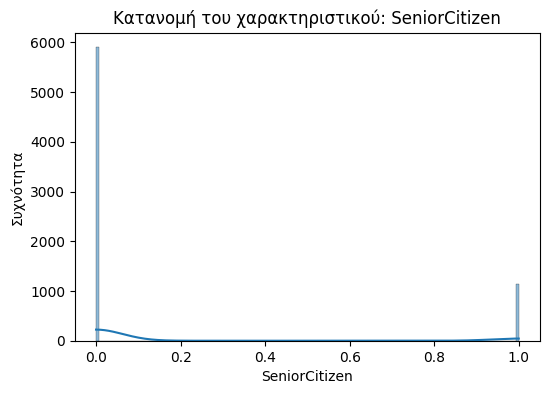

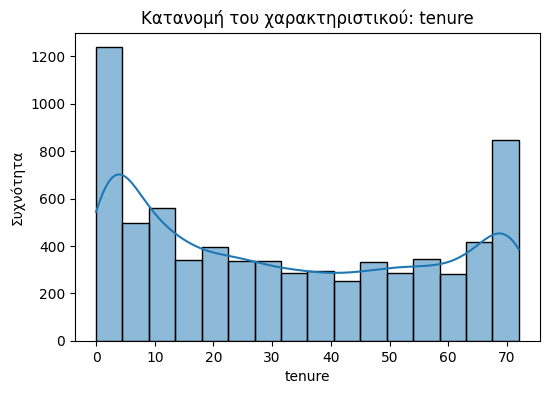

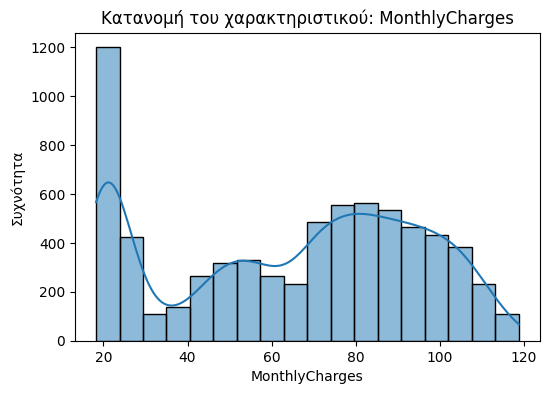

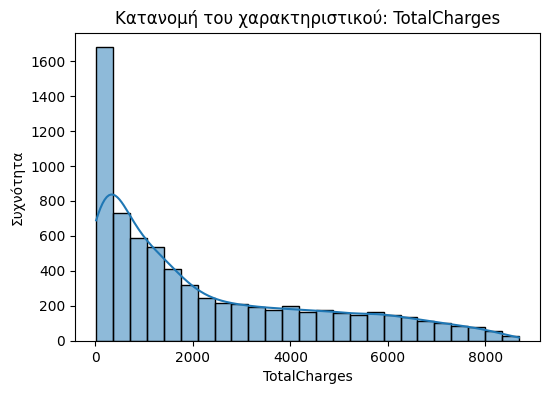

Κατηγορικά χαρακτηριστικά: ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'Churn']
                 Τιμή με τη Μέγιστη Συχνότητα  Συχνότητα Ποσοστό (%)
gender                                   Male       3555       50.48
Partner                                    No       3641       51.70
Dependents                                 No       4933       70.04
PhoneService                              Yes       6361       90.32
MultipleLines                              No       3390       48.13
InternetService                   Fiber optic       3096       43.96
OnlineSecurity                             No       3498       49.67
OnlineBackup                               No       3088       43.84
DeviceProtection                           No       3095       43.94
TechSupport                       

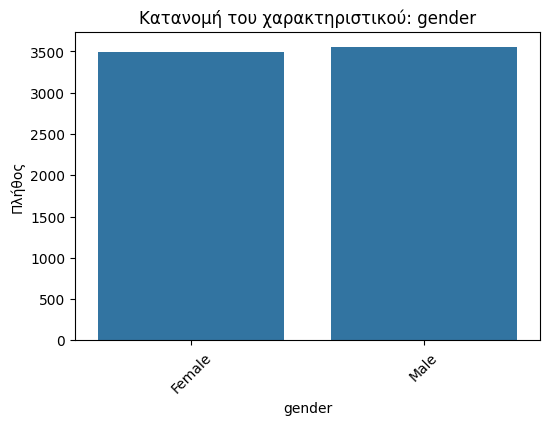

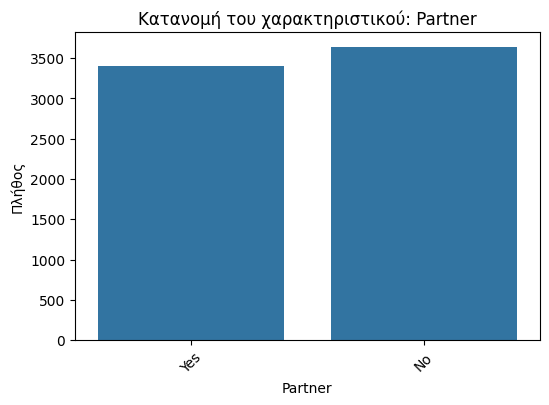

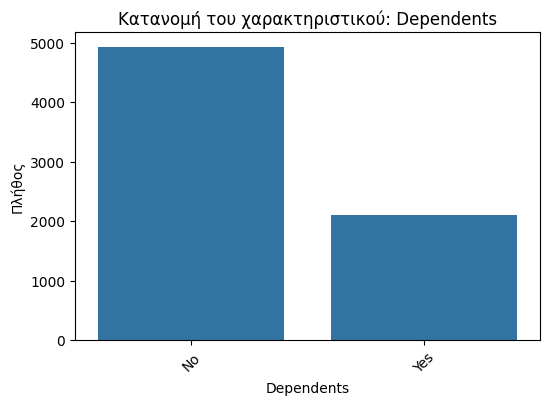

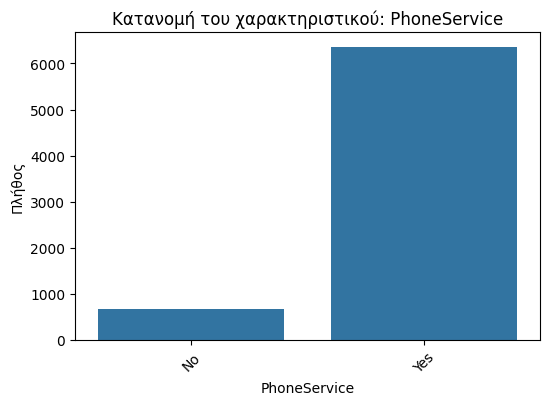

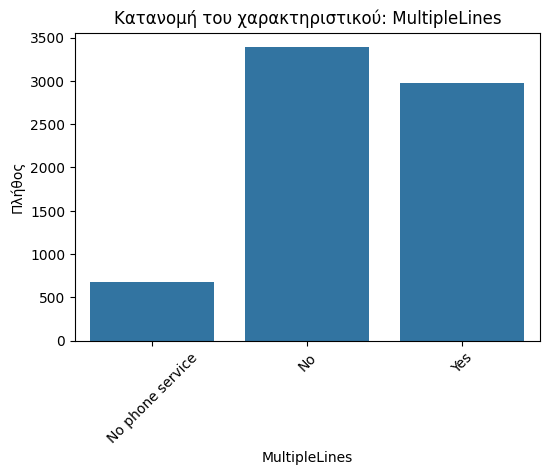

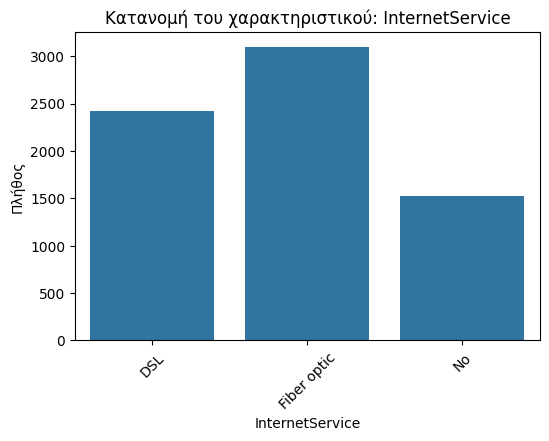

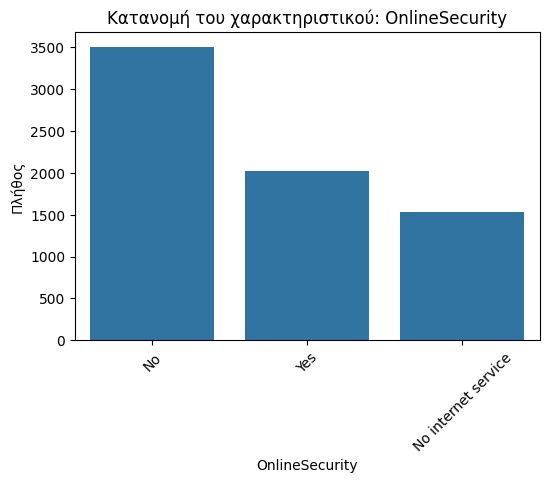

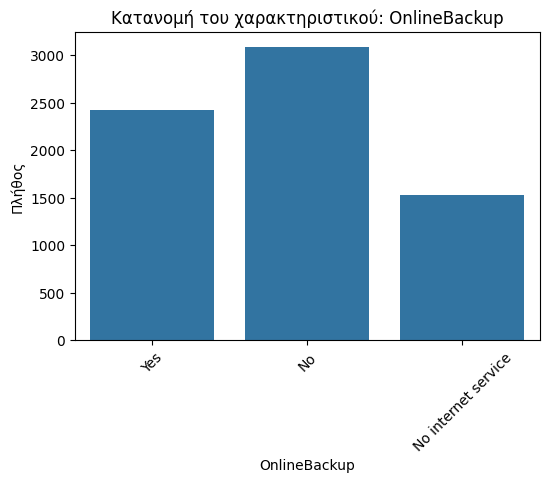

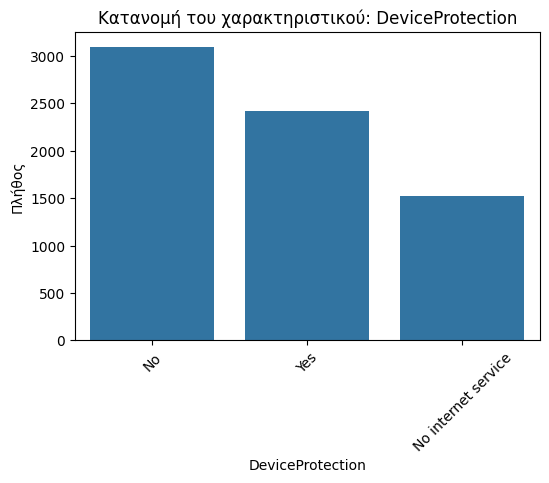

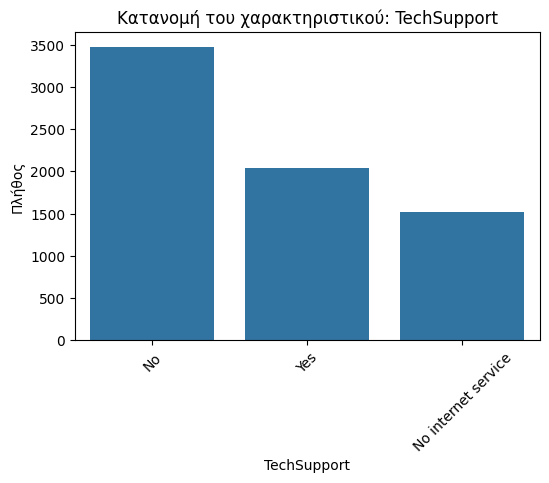

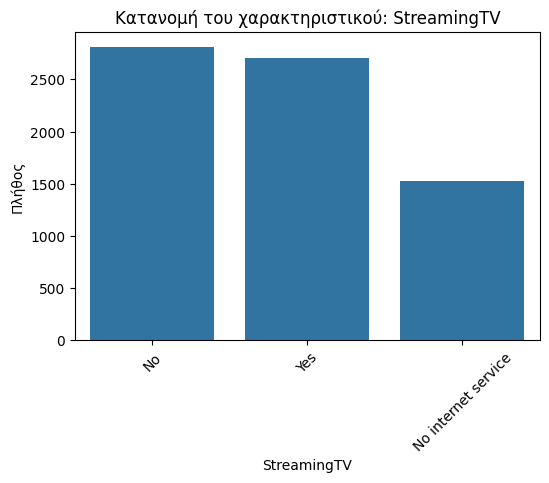

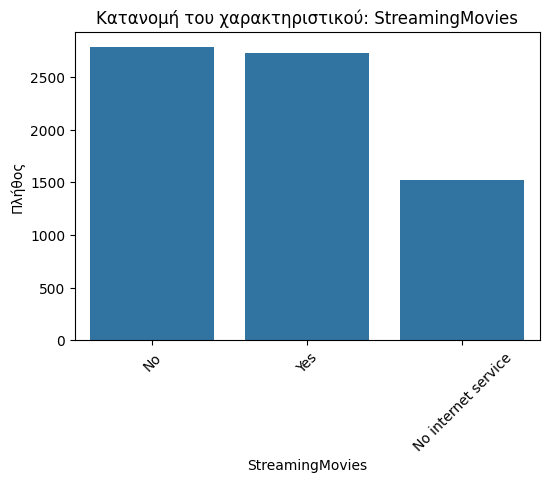

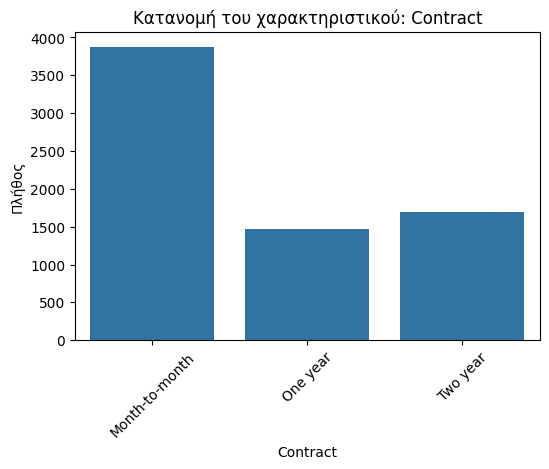

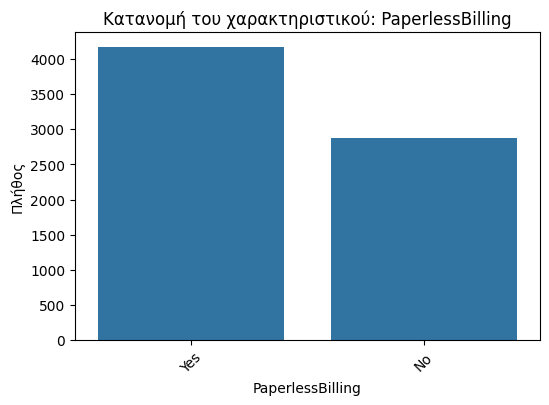

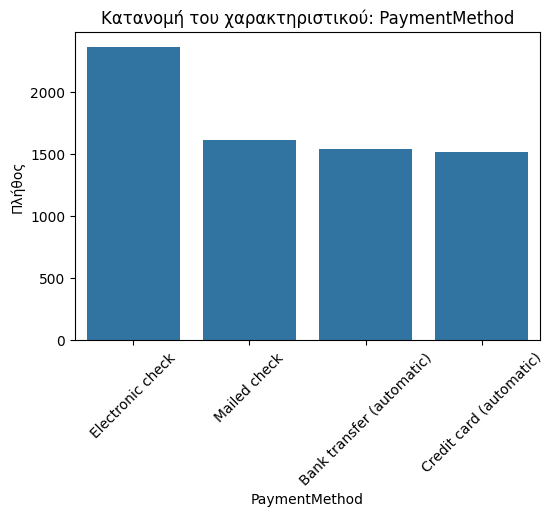

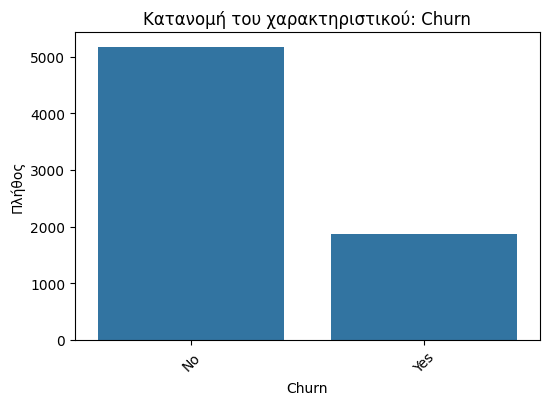

In [3]:
# Μετατροπή του χαρακτηριστικού TotalCharges σε κατάλληλο τύπο δεδομένων.
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
# Δυναμική δημιουργία γραφημάτων για κάθε χαρακτηριστικό.
def plot_distributions(df):
    
    # Διαχωρισμός αριθμητικών χαρακτηριστικών χαρακτηριστικών.
    numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
    print("Αριθμητικά χαρακτηριστικά:", list(numeric_cols))
    num_summary = pd.DataFrame({
        "Ελάχιστο": df[numeric_cols].min(),
        "Μέγιστο": df[numeric_cols].max(),
        "Μέση Τιμή": df[numeric_cols].mean(),
        "Διάμεσος": df[numeric_cols].median()
    })
    print(num_summary)
    # Διάγραμμα για αριθμητικά χαρακτηριστικά
    for col in numeric_cols:
        plt.figure(figsize=(6,4))
        sns.histplot(df[col], kde=True)
        plt.title(f"Κατανομή του χαρακτηριστικού: {col}")
        plt.xlabel(col)
        plt.ylabel("Συχνότητα")
        plt.show()
    # Διαχωρισμός κατηγορικών χαρακτηριστικών.
    categorical_cols = df.select_dtypes(include=['object']).columns[1:]
    print("Κατηγορικά χαρακτηριστικά:", list(categorical_cols))
    cat_summary = pd.DataFrame({
        "Τιμή με τη Μέγιστη Συχνότητα": df[categorical_cols].agg(lambda x: x.value_counts().idxmax()),
        "Συχνότητα": df[categorical_cols].agg(lambda x: x.value_counts().max()),
        "Ποσοστό (%)": df[categorical_cols].agg(lambda x: x.value_counts().max() / len(x) * 100).map("{:.2f}".format)
    })
    print(cat_summary)
    # Διάγραμμα για κατηγορικά χαρακτηριστικά
    for col in categorical_cols:
        plt.figure(figsize=(6,4))
        sns.countplot(data=df, x=col)
        plt.title(f"Κατανομή του χαρακτηριστικού: {col}")
        plt.xlabel(col)
        plt.ylabel("Πλήθος")
        plt.xticks(rotation=45)
        plt.show()

# Εμφάνιση των γραφημάτων.
plot_distributions(df)

### Εκτελέστε καθαρισμό και προεπεξεργασία δεδομένων (Χειρισμός τιμών που λείπουν, Κωδικοποίηση κατηγορικών μεταβλητών, Κανονικοποίηση/τυποποίηση). Δικαιολογήστε τις αποφάσεις προεπεξεργασίας σας

In [4]:
# Διαχείριση των ελλειπόντων τιμών για κάθε χαρακτηριστικό.
missing_values = pd.DataFrame({
    "#_values": len(df),
    "n_missing": df.isna().sum(),
    "pct_missing": ((df.isna().sum() / len(df)) * 100).map("{:.02f}".format),
})
print(missing_values.sort_values(by="n_missing", ascending=False))

# Για την αποφυγή απώλειας δεδομένων, συμπληρώνουμε τις ελλειπόντες τιμές με τον τύπο: TotalCharges = MonthlyCharges * tenure.
df['TotalCharges'] = df.apply(lambda row: row['MonthlyCharges'] * row['tenure'] if pd.isna(row['TotalCharges']) else row['TotalCharges'],axis=1)

print(50*"-")
print(f"Αριθμός ελλειπόντων τιμών στο TotalCharges μετά την αντικατάσταση: {df['TotalCharges'].isna().sum()}")
print(f"Μέγεθος του DataFrame: {df.shape}")

                  #_values  n_missing pct_missing
TotalCharges          7043         11        0.16
gender                7043          0        0.00
SeniorCitizen         7043          0        0.00
Partner               7043          0        0.00
customerID            7043          0        0.00
Dependents            7043          0        0.00
tenure                7043          0        0.00
MultipleLines         7043          0        0.00
PhoneService          7043          0        0.00
OnlineSecurity        7043          0        0.00
OnlineBackup          7043          0        0.00
DeviceProtection      7043          0        0.00
InternetService       7043          0        0.00
TechSupport           7043          0        0.00
StreamingTV           7043          0        0.00
Contract              7043          0        0.00
StreamingMovies       7043          0        0.00
PaperlessBilling      7043          0        0.00
PaymentMethod         7043          0        0.00


In [5]:
# Μετατροπή κατηγορικών χαρακτηριστικών  με χρήση one-hot encoding.
# Αφαίρεση της στήλης customerID
df = df.drop(columns=['customerID'])

# Μετατροπή της μεταβλητής στόχου σε αριθημητική 
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

# Μετατροπή της μεταβλητής SeniorCitizen σε κατηγορική
df['SeniorCitizen'] = df['SeniorCitizen'].astype('object')

# One-hot encode σε όλα τα κατηγορικά χαρακτηριστικά
cat_cols = df.select_dtypes(include=['object']).columns

# Στην κωδικοποιήση για τη Λογιστική Παλλινδρόμηση, χρησιμοποιούμε drop_first=True για να αποφύγουμε την παγίδα της πολυσυλλεκτικότητας (multicollinearity) 
df_encoded_LR = pd.get_dummies(df, columns=cat_cols, drop_first=True)

# Στην κωδικοποιήση για τη Νευρωνικά Δίκτυα, χρησιμοποιούμε drop_first=False για να διατηρήσουμε όλες τις κατηγορίες
df_encoded_NN = pd.get_dummies(df, columns=cat_cols, drop_first=False)

print("Μέγεθος του DataFrame για τη Λογιστική Παλλινδρόμηση μετά την κωδικοποίηση:", df_encoded_LR.shape)
print("Μέγεθος του DataFrame για τα Νευρωνικά Δίκτυα μετά την κωδικοποίηση:", df_encoded_NN.shape)

Μέγεθος του DataFrame για τη Λογιστική Παλλινδρόμηση μετά την κωδικοποίηση: (7043, 31)
Μέγεθος του DataFrame για τα Νευρωνικά Δίκτυα μετά την κωδικοποίηση: (7043, 47)


In [6]:
# Προετοιμασία των δεδομένων για κανονικοποιήση

# Διαχωρισμός χαρακτηριστικών και μεταβλητής στόχου
y = df_encoded_LR["Churn"]
X_LR = df_encoded_LR.drop(columns=["Churn"])
X_NN = df_encoded_NN.drop(columns=["Churn"])

# Διαχωρισμός σε σετ εκπαίδευσης και δοκιμής
X_train_LR, X_test_LR, y_train_LR, y_test_LR = train_test_split(
    X_LR, y, test_size=0.2, random_state=42, stratify=y
)
X_train_NN, X_test_NN, y_train_NN, y_test_NN = train_test_split(
    X_NN, y, test_size=0.2, random_state=42, stratify=y
)

# Εκτύπωση των ποσοστών της μεταβλητής στόχου στα σετ εκπαίδευσης και δοκιμής για κάθε μοντέλο
print('Ποσοστό εκπαίδευσης για μεταβλητή στόχο στη λογιστική παλινδρόμηση: ', ("{:.02f}".format(y_train_LR.sum() / len(y_train_LR))))
print('Ποσοστό δοκιμής για μεταβλητή στόχο στη λογιστική παλινδρόμηση: ', ("{:.02f}".format(y_test_LR.sum() / len(y_test_LR))))
print(80*'-')
print('Ποσοστό εκπαίδευσης για μεταβλητή στόχο στο νευρωνικό δίκτυο: ', ("{:.02f}".format(y_train_NN.sum() / len(y_train_NN))))
print('Ποσοστό δοκιμής για μεταβλητή στόχο στο νευρωνικό δίκτυο: ', ("{:.02f}".format(y_test_NN.sum() / len(y_test_NN))))

Ποσοστό εκπαίδευσης για μεταβλητή στόχο στη λογιστική παλινδρόμηση:  0.27
Ποσοστό δοκιμής για μεταβλητή στόχο στη λογιστική παλινδρόμηση:  0.27
--------------------------------------------------------------------------------
Ποσοστό εκπαίδευσης για μεταβλητή στόχο στο νευρωνικό δίκτυο:  0.27
Ποσοστό δοκιμής για μεταβλητή στόχο στο νευρωνικό δίκτυο:  0.27


In [7]:
# Κανονικοποιηση των χαρακτηριστικών
# Λογιστική Παλινδρόμηση με StandardScaler
scaler_LR = StandardScaler()
X_train_LR[X_train_LR.columns] = scaler_LR.fit_transform(X_train_LR)
X_test_LR[X_test_LR.columns] = scaler_LR.transform(X_test_LR)

# Νευρωνικό Δίκτυο με MinMaxScaler
scaler_NN = MinMaxScaler()
X_train_NN[X_train_NN.columns] = scaler_NN.fit_transform(X_train_NN)
X_test_NN[X_test_NN.columns] = scaler_NN.transform(X_test_NN)

## 2.Βασικό Γραμμικό Μοντέλο: Logistic Regression 

### Υλοποιήστε ένα μοντέλο Λογιστικής Παλινδρόμησης ως βάση

ROC-AUC για σετ δοκιμής (προεπιλεγμένο C): 0.84
--------------------------------------------------


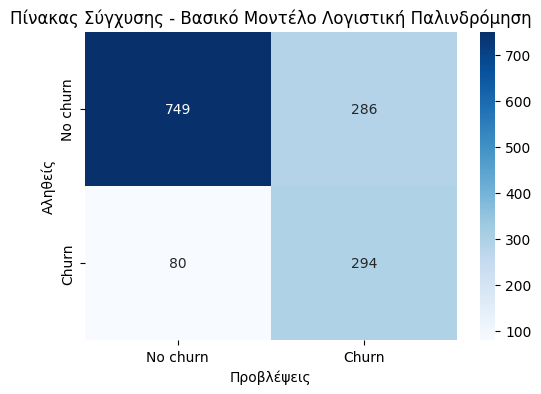

Πίνακας Ταξινόμησης Βασικό Μοντέλο Λογιστικής Παλινδρόμησης:
              precision    recall  f1-score   support

           0       0.90      0.72      0.80      1035
           1       0.51      0.79      0.62       374

    accuracy                           0.74      1409
   macro avg       0.71      0.75      0.71      1409
weighted avg       0.80      0.74      0.75      1409



In [8]:
# Εκπαίδευση Βασικού Μοντέλου Λογιστικής Παλινδρόμησης 
lr_baseline = LogisticRegression(max_iter=1000, class_weight='balanced')   # Προεπιλογές: C=1.0, threshold=0.5
lr_baseline.fit(X_train_LR, y_train_LR) 

# Προβλέψεις Βασικού Μοντέλου Λογιστικής Παλινδρόμησης
y_pred_LR = lr_baseline.predict(X_test_LR)
y_pred_prob_LR = lr_baseline.predict_proba(X_test_LR)[:, 1]

# Μετρικά απόδοσης Βασικού Μοντέλου Λογιστικής Παλινδρόμησης
print("ROC-AUC για σετ δοκιμής (προεπιλεγμένο C):", format(roc_auc_score(y_test_LR, y_pred_prob_LR), ".2f"))
print(50*"-")

# Πίνακας Σύγχυσης (Confusion Matrix) Βασικού Μοντέλου Λογιστικής Παλινδρόμησης
cm_baseline_lr = confusion_matrix(y_test_LR, y_pred_LR)
plt.figure(figsize=(6,4))
sns.heatmap(cm_baseline_lr, annot=True, fmt='d', cmap='Blues', xticklabels=['No churn','Churn'], yticklabels=['No churn','Churn'])
plt.title("Πίνακας Σύγχυσης - Βασικό Μοντέλο Λογιστική Παλινδρόμηση")
plt.xlabel("Προβλέψεις")
plt.ylabel("Αληθείς")
plt.show()

# Πίνακας Ταξινόμησης Βασικού Μοντέλου Λογιστικής Παλινδρόμησης
print("Πίνακας Ταξινόμησης Βασικό Μοντέλο Λογιστικής Παλινδρόμησης:")
print(classification_report(y_test_LR, y_pred_LR))

### Αναφέρετε αποτελέσματα χρησιμοποιώντας σχετικές μετρήσεις απόδοσης (ακρίβεια, επαναληψιμότητα, ανάκληση, βαθμολογία F1, ROC-AUC)

In [9]:
# Εκπαίδευση Εναλλακτικού Μοντέλου Λογιστικής Παλινδρόμησης  
lr_alt = LogisticRegression(
    max_iter=1000,
    penalty='l2',
    class_weight='balanced',
    solver='lbfgs'   # επειδή έχουμε κανονικοποίηση L2
)

# Πλέγμα παραμέτρων για υπερπαράμετρο C
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100]
}
# Στρατηγική Cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# GridSearchCV
grid_search = GridSearchCV(
    estimator=lr_alt,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=cv,
    n_jobs=-1,
    verbose=1
)

# Προσαρμογή πλέγματος αναζήτησης (grid search) στα δεδομένα εκπαίδευσης
grid_search.fit(X_train_LR, y_train_LR)
print("Βέλτιστο C:", grid_search.best_params_['C'])
print("Καλύτερο ROC-AUC κατά τη διάρκεια του CV:", format(grid_search.best_score_, ".2f"))
print(50*"-")

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Βέλτιστο C: 10
Καλύτερο ROC-AUC κατά τη διάρκεια του CV: 0.85
--------------------------------------------------


ROC-AUC για σετ δοκιμής (βέλτιστο C): 0.84
--------------------------------------------------


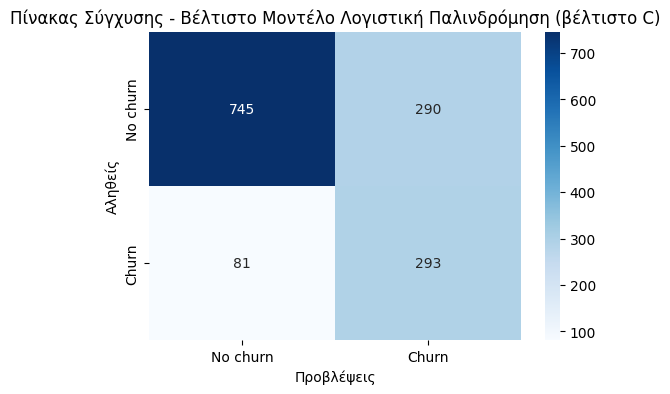

Πίνακας Ταξινόμησης Βέλτιστο Μοντέλο Λογιστική Παλινδρόμηση (βέλτιστο C):
              precision    recall  f1-score   support

           0       0.90      0.72      0.80      1035
           1       0.50      0.78      0.61       374

    accuracy                           0.74      1409
   macro avg       0.70      0.75      0.71      1409
weighted avg       0.80      0.74      0.75      1409



In [10]:
# Αποθήκευση βέλτιστης τιμής για την υπερπαράμετρο C
best_C = grid_search.best_params_['C']
# Εκπαίδευση Βέλτιστου Μοντέλου Λογιστικής Παλινδρόμησης με την καλύτερη τιμή C
lr_best = LogisticRegression(
    max_iter=1000,
    penalty='l2',
    class_weight='balanced',
    solver='lbfgs',
    C=best_C
)
lr_best.fit(X_train_LR, y_train_LR)

# Προβλέψεις Βέλτιστου Μοντέλου Λογιστικής Παλινδρόμησης
y_pred_bestC = lr_best.predict(X_test_LR)
y_prob_bestC = lr_best.predict_proba(X_test_LR)[:, 1]
print("ROC-AUC για σετ δοκιμής (βέλτιστο C):", format(roc_auc_score(y_test_LR, y_prob_bestC), ".2f"))
print(50*"-")

# Πίνακας Σύγχυσης (Confusion Matrix) Βέλτιστου Μοντέλου Λογιστικής Παλινδρόμησης
cm_best_lr = confusion_matrix(y_test_LR, y_pred_bestC)
plt.figure(figsize=(6,4))
sns.heatmap(cm_best_lr, annot=True, fmt='d', cmap='Blues', xticklabels=['No churn','Churn'], yticklabels=['No churn','Churn'])
plt.title("Πίνακας Σύγχυσης - Βέλτιστο Μοντέλο Λογιστική Παλινδρόμηση (βέλτιστο C)")
plt.xlabel("Προβλέψεις")
plt.ylabel("Αληθείς")
plt.show()

# Πίνακας Ταξινόμησης Βέλτιστου Μοντέλου Λογιστικής Παλινδρόμησης
print("Πίνακας Ταξινόμησης Βέλτιστο Μοντέλο Λογιστική Παλινδρόμηση (βέλτιστο C):")
print(classification_report(y_test_LR, y_pred_bestC))

Καλύτερο κατώφλι (με βάση το F1): 0.57
Επαναληψιμότητα στο βέλτιστο κατώφλι: 0.537
Ανάκληση στο βέλτιστο κατώφλι: 0.738
F1-score στο βέλτιστο κατώφλι: 0.622


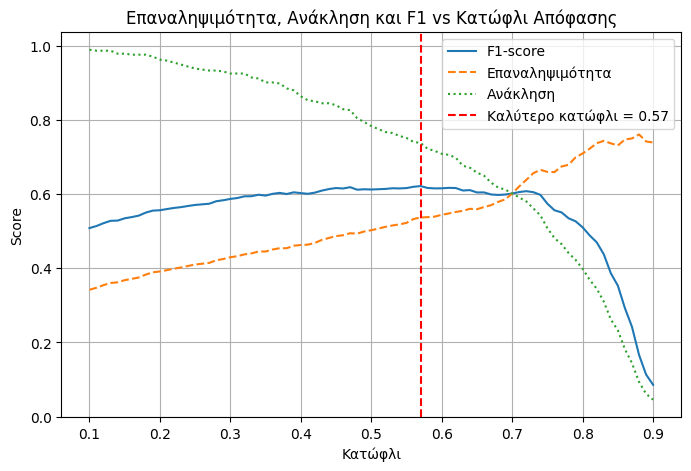

In [11]:
# Οριοθέτηση εύρους κατωφλίων για δοκιμή
thresholds = np.linspace(0.1, 0.9, 81)  # 0.10, 0.11, ..., 0.89, 0.90
f1_scores = []
precisions = []
recalls = []

for th in thresholds:
    y_pred_th = (y_prob_bestC >= th).astype(int)
    precisions.append(precision_score(y_test_LR, y_pred_th))
    recalls.append(recall_score(y_test_LR, y_pred_th))
    f1_scores.append(f1_score(y_test_LR, y_pred_th))

# Επιλογή κατωφλίου που μεγιστοποιεί το F1-score, καθώς θέλουμε ισορροπία μεταξύ precision και recall
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]

print(f"Καλύτερο κατώφλι (με βάση το F1): {best_threshold:.2f}")
print(f"Επαναληψιμότητα στο βέλτιστο κατώφλι: {precisions[best_idx]:.3f}")
print(f"Ανάκληση στο βέλτιστο κατώφλι: {recalls[best_idx]:.3f}")
print(f"F1-score στο βέλτιστο κατώφλι: {f1_scores[best_idx]:.3f}")

# Δίαγραμμα Επαναληψιμότητα / Ανάκλησης / F1 vs Κατώφλι
plt.figure(figsize=(8,5))
plt.plot(thresholds, f1_scores, label="F1-score")
plt.plot(thresholds, precisions, label="Επαναληψιμότητα", linestyle='--')
plt.plot(thresholds, recalls, label="Ανάκληση", linestyle=':')
plt.axvline(best_threshold, color='red', linestyle='--', label=f"Καλύτερο κατώφλι = {best_threshold:.2f}")
plt.xlabel("Κατώφλι")
plt.ylabel("Score")
plt.title("Επαναληψιμότητα, Ανάκληση και F1 vs Κατώφλι Απόφασης")
plt.legend()
plt.grid(True)
plt.show()

# Προβλέψεις με χρήση του βέλτιστου κατωφλίου
y_pred_best_thresh = (y_prob_bestC >= best_threshold).astype(int)

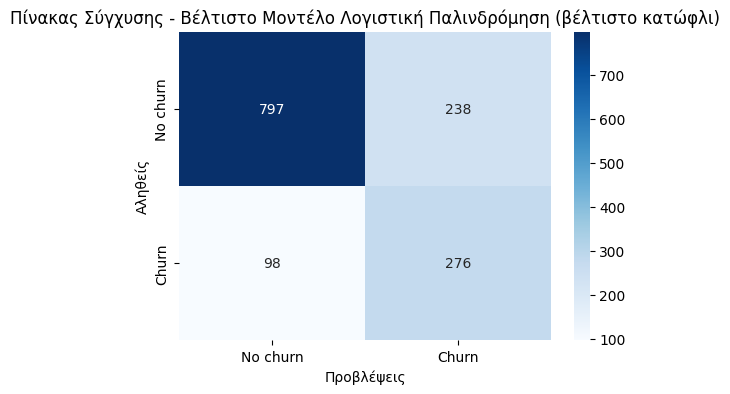

Πίνακας Ταξινόμησης Βέλτιστο Μοντέλο Λογιστική Παλινδρόμηση (βέλτιστο κατώφλι):
              precision    recall  f1-score   support

           0       0.89      0.77      0.83      1035
           1       0.54      0.74      0.62       374

    accuracy                           0.76      1409
   macro avg       0.71      0.75      0.72      1409
weighted avg       0.80      0.76      0.77      1409



In [12]:
# Πίνακας Σύγχυσης (Confusion Matrix) Βέλτιστου Μοντέλου Λογιστικής Παλινδρόμησης
cm_best_thres_lr = confusion_matrix(y_test_LR, y_pred_best_thresh)
plt.figure(figsize=(6,4))
sns.heatmap(cm_best_thres_lr, annot=True, fmt='d', cmap='Blues', xticklabels=['No churn','Churn'], yticklabels=['No churn','Churn'])
plt.title("Πίνακας Σύγχυσης - Βέλτιστο Μοντέλο Λογιστική Παλινδρόμηση (βέλτιστο κατώφλι)")
plt.xlabel("Προβλέψεις")
plt.ylabel("Αληθείς")
plt.show()

# Πίνακας Ταξινόμησης Βέλτιστου Μοντέλου Λογιστικής Παλινδρόμησης
print("Πίνακας Ταξινόμησης Βέλτιστο Μοντέλο Λογιστική Παλινδρόμηση (βέλτιστο κατώφλι):")
print(classification_report(y_test_LR, y_pred_best_thresh))

## 3.Μοντέλο Νευρωνικού Δικτύου με TensorFlow

### Σχεδιάστε και υλοποιήστε ένα νευρωνικό δίκτυο feedforward (MLP) σε TensorFlow/Keras

In [13]:
# Αριθμός εισόδων στο νευρωνικό δίκτυο
input_dim = X_train_NN.shape[1]
print("Number of input features:", input_dim)

# Δημιουργία απλού Νευρωνικού Δικτύου MLP
nn_baseline = keras.Sequential()
# Αρχικό + πρώτο κρυφό επίπεδο
nn_baseline.add(layers.Input(shape=(input_dim,)))
nn_baseline.add(layers.Dense(64, activation='relu'))
# Δεύτερο κρυφό επίπεδο
nn_baseline.add(layers.Dense(32, activation='relu'))
# Τρίτο κρυφό επίπεδο 
nn_baseline.add(layers.Dense(16, activation='relu'))
# Επίπεδο εξόδου για δυαδική ταξινόμηση
nn_baseline.add(layers.Dense(1, activation='sigmoid'))
# Compile του μοντέλου
nn_baseline.compile(
    optimizer=keras.optimizers.Adam(),
    loss='binary_crossentropy',
    metrics=['accuracy']
)
# Αρχιτεκτονική 
nn_baseline.summary()

Number of input features: 46


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         3,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,633 (22.00 KB)

 Trainable params: 5,633 (22.00 KB)

 Non-trainable params: 0 (0.00 B)

### Υπερβείτε μια απλή αρχιτεκτονική πειραματιζόμενοι με προηγμένες τεχνικές: (Ομαλοποίηση παρτίδας, Κανονικοποίηση απόρριψης και L1/L2, Υπολειπόμενες/παράλειψη συνδέσεων)

In [14]:
# Δημιουργία απλού Νευρωνικού Δικτύου MLP με αυξημένη πολυπλοκότητα 
nn_alt= keras.Sequential()

# Αρχικό + πρώτο κρυφό επίπεδο
nn_alt.add(layers.Input(shape=(input_dim,)))
nn_alt.add(layers.Dense(
    64,
    activation='relu',
    kernel_regularizer=regularizers.l2(1e-4)
))
nn_alt.add(layers.BatchNormalization()) # Ομαλοποίηση παρτίδας
nn_alt.add(layers.Dropout(0.3)) # Κανονικοποίηση Απόρριψης
# Δεύτερο κρυφό επίπεδο
nn_alt.add(layers.Dense(
    32,
    activation='relu',
    kernel_regularizer=regularizers.l2(1e-4)
))
nn_alt.add(layers.BatchNormalization())
nn_alt.add(layers.Dropout(0.3))
# Τρίτο κρυφό επίπεδο
nn_alt.add(layers.Dense(
    16,
    activation='relu',
    kernel_regularizer=regularizers.l2(1e-4)
))
# Επίπεδο εξόδου για δυαδική ταξινόμηση
nn_alt.add(layers.Dense(1, activation='sigmoid'))

# Compile του μοντέλου
nn_alt.compile(
    optimizer=keras.optimizers.Adam(),
    loss='binary_crossentropy',
    metrics=['accuracy']
)
# Αρχιτεκτονική
nn_alt.summary()

# Ορισμός Early Stopping
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 64)             │         3,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,017 (23.50 KB)

 Trainable params: 5,825 (22.75 KB)

 Non-trainable params: 192 (768.00 B)

Epoch 1/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.6335 - loss: 0.6517 - val_accuracy: 0.7684 - val_loss: 0.5504
Epoch 2/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7670 - loss: 0.4853 - val_accuracy: 0.7737 - val_loss: 0.4898
Epoch 3/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7786 - loss: 0.4735 - val_accuracy: 0.7737 - val_loss: 0.4753
Epoch 4/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7808 - loss: 0.4626 - val_accuracy: 0.7711 - val_loss: 0.4677
Epoch 5/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7890 - loss: 0.4495 - val_accuracy: 0.7782 - val_loss: 0.4642
Epoch 6/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7990 - loss: 0.4407 - val_accuracy: 0.7782 - val_loss: 0.4624
Epoch 7/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7890 - loss: 0.4466 - val_accuracy: 0.7755 - val_loss: 0.4607
Epoch 8/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7870 - loss: 0.4462 - val_accuracy: 0.7862 -

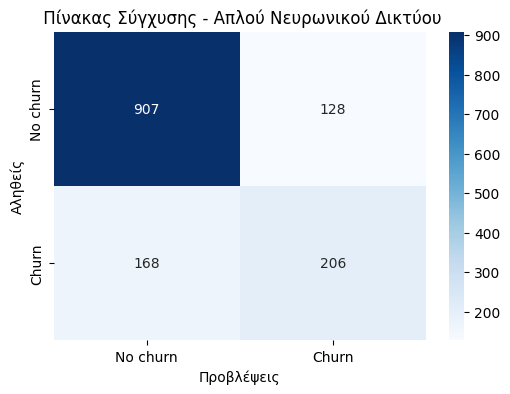

Πίνακας Ταξινόμησης Απλού Νευρωνικού Δικτύου:
              precision    recall  f1-score   support

    No churn       0.84      0.88      0.86      1035
       Churn       0.62      0.55      0.58       374

    accuracy                           0.79      1409
   macro avg       0.73      0.71      0.72      1409
weighted avg       0.78      0.79      0.79      1409



In [15]:
# Εκπαίδευση του απλού Νευρωνικού Δικτύου MLP με αυξημένη πολυπλοκότητα 
history = nn_alt.fit(
    X_train_NN,
    y_train_NN,
    validation_split=0.2,   
    epochs=100,            
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)

# Προβλέψεις απλού Νευρωνικού Δικτύου MLP με αυξημένη πολυπλοκότητα 
y_prob_nn = nn_alt.predict(X_test_NN).ravel()          # shape: (n_samples,)
y_pred_nn = (y_prob_nn >= 0.5).astype(int) 

# Μετρικά απόδοσης απλού Νευρωνικού Δικτύου MLP με αυξημένη πολυπλοκότητα 
print("Απόδοση Απλού Νευρωνικού Δικτύου (κατώφλι = 0.5):")
print(f"ROC-AUC:  {roc_auc_score(y_test_NN, y_prob_nn):.2f}")
print(50*"-")

# Πίνακας Σύγχυσης (Confusion Matrix) απλού Νευρωνικού Δικτύου MLP με αυξημένη πολυπλοκότητα
cm_nn = confusion_matrix(y_test_NN, y_pred_nn)
plt.figure(figsize=(6,4))
sns.heatmap(cm_nn,annot=True,fmt='d',cmap='Blues',xticklabels=['No churn', 'Churn'],yticklabels=['No churn', 'Churn'])
plt.title(" Πίνακας Σύγχυσης - Απλού Νευρωνικού Δικτύου")
plt.xlabel("Προβλέψεις")
plt.ylabel("Αληθείς")
plt.show()

# Πίνακας Ταξινόμησης Απλού Νευρωνικού Δικτύου MLP με αυξημένη πολυπλοκότητα
print("Πίνακας Ταξινόμησης Απλού Νευρωνικού Δικτύου:")
print(classification_report(y_test_NN, y_pred_nn, target_names=['No churn', 'Churn']))

### Εκτελέστε ρύθμιση υπερπαραμέτρων (π.χ., χρησιμοποιώντας KerasTuner ή Optuna)

In [16]:
# Ορισμός συνάρτησης για τη δημιουργία μοντέλου Keras με υπερπαραμέτρους
def build_model(hp) -> keras.Model:
    model = keras.Sequential()

     # Αρχικό επίπεδο
    model.add(layers.Input(shape=(input_dim,)))
    # Αριθμός κρυφών επιπέδων: 2, 3 ή 4
    num_layers = hp.Int('num_layers', min_value=2, max_value=4, step=1)
    # Κοινές υπερπαραμέτροι
    dropout_rate = hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1)
    l2_strength = hp.Choice('l2_strength', values=[1e-3, 1e-4, 1e-5])
    
    # Πρώτο κρυφό επίπεδο
    units_1 = hp.Int('units_1', min_value=32, max_value=128, step=32)
    model.add(layers.Dense(
        units_1,
        activation='relu',
        kernel_regularizer=regularizers.l2(l2_strength)
    ))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(dropout_rate))
    # Δεύτερο κρυφό επίπεδο
    units_2 = hp.Int('units_2', min_value=16, max_value=64, step=16)
    model.add(layers.Dense(
        units_2,
        activation='relu',
        kernel_regularizer=regularizers.l2(l2_strength)
    ))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(dropout_rate))
    # Τρίτο κρυφό επίπεδο (μόνο αν num_layers == 3)
    if num_layers == 3:
        units_3 = hp.Int('units_3', min_value=16, max_value=64, step=16)
        model.add(layers.Dense(
            units_3,
            activation='relu',
            kernel_regularizer=regularizers.l2(l2_strength)
        ))
    # Τέταρτο κρυφό επίπεδο (μόνο αν num_layers == 4)
    if num_layers == 4:
        units_4 = hp.Int('units_4', min_value=16, max_value=32, step=8)
        model.add(layers.Dense(
            units_4,
            activation='relu',
            kernel_regularizer=regularizers.l2(l2_strength)
        ))
    # Επίπεδο εξόδου
    model.add(layers.Dense(1, activation='sigmoid'))
    
    # Ρυθμός εκμάθησης
    learning_rate = hp.Choice('learning_rate', values=[1e-2, 5e-3, 1e-3])
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy',
            keras.metrics.AUC(name='auc')  # ROC-AUC κατά την εκπαίδευση
        ]
    )
    return model

In [17]:
# Δημιουργία του Tuner για τυχαία αναζήτηση (Random Search)
tuner = kt.RandomSearch(
    hypermodel=build_model,
    objective='val_auc',         # μεγιστοποιήση του AUC
    max_trials=10,               # συνολικά 10 δοκιμές
    executions_per_trial=1,      # εκπαίδευση κάθε συνδυασμού μία φορά
    overwrite=True,
    directory='NN_project',
    project_name='nn_model_tuning'
)

# Αναζήτηση των βέλτιστων υπερπαραμέτρων για εναλλακτικό Νευρωνικό Δίκτυο MLP
tuner.search(
    X_train_NN,
    y_train_NN,
    validation_split=0.2,
    epochs=100,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)

# Περίληψη των αποτελεσμάτων της αναζήτησης
tuner.results_summary()
print(50*"-")

# Αποθήκευση των βέλτιστων υπερπαραμέτρων και του εναλλακτικό Νευρωνικό Δίκτυο MLP
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.get_best_models(num_models=1)[0]

print("Βέλτιστες υπερπαράμετροι:")
for param in best_hp.values.keys():
    print(param, ":", best_hp.get(param))

Trial 10 Complete [00h 00m 20s]
val_auc: 0.8227061033248901

Best val_auc So Far: 0.8297017812728882
Total elapsed time: 00h 03m 57s
Results summary
Results in NN_project\nn_model_tuning
Showing 10 best trials
Objective(name="val_auc", direction="max")

Trial 01 summary
Hyperparameters:
num_layers: 3
dropout_rate: 0.2
l2_strength: 0.0001
units_1: 32
units_2: 48
learning_rate: 0.005
units_3: 16
Score: 0.8297017812728882

Trial 00 summary
Hyperparameters:
num_layers: 2
dropout_rate: 0.30000000000000004
l2_strength: 0.0001
units_1: 32
units_2: 48
learning_rate: 0.005
Score: 0.8257700204849243

Trial 06 summary
Hyperparameters:
num_layers: 2
dropout_rate: 0.4
l2_strength: 1e-05
units_1: 64
units_2: 64
learning_rate: 0.005
units_3: 48
units_4: 16
Score: 0.8250081539154053

Trial 02 summary
Hyperparameters:
num_layers: 4
dropout_rate: 0.30000000000000004
l2_strength: 0.001
units_1: 64
units_2: 16
learning_rate: 0.01
units_3: 32
units_4: 16
Score: 0.8236269950866699

Trial 07 summary
Hyperpar

c:\Users\user\Desktop\nn_dl_projct_312\nn_dl_proj312\Lib\site-packages\keras\src\saving\saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Απόδοση Εναλλακτικού Νευρωνικού Δικτύου (κατώφλι = 0.5):
ROC-AUC:   0.8323


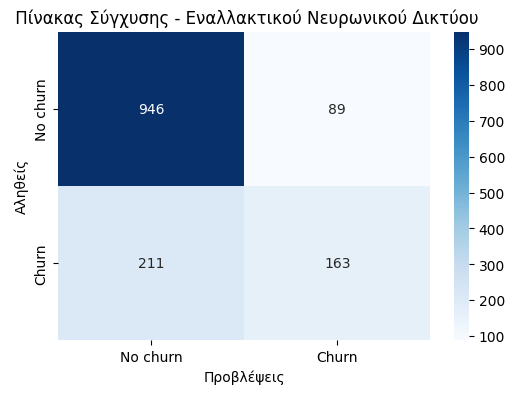

Πίνακας ταξινόμησης Εναλλακτικού Νευρωνικού Δικτύου:
              precision    recall  f1-score   support

    No churn       0.82      0.91      0.86      1035
       Churn       0.65      0.44      0.52       374

    accuracy                           0.79      1409
   macro avg       0.73      0.67      0.69      1409
weighted avg       0.77      0.79      0.77      1409



In [18]:
# Προβλέψεις του εναλλακτικού Νευρωνικού Δικτύου MLP
y_prob_nn_tuned = best_model.predict(X_test_NN).ravel()
y_pred_nn_tuned = (y_prob_nn_tuned >= 0.5).astype(int)

# Μετρικά απόδοσης του εναλλακτικού Νευρωνικού Δικτύου MLP 
roc_auc_nn_tuned = roc_auc_score(y_test_NN, y_prob_nn_tuned)

print("Απόδοση Εναλλακτικού Νευρωνικού Δικτύου (κατώφλι = 0.5):")
print(f"ROC-AUC:   {roc_auc_nn_tuned:.4f}")

# Πίνακας Σύγχυσης (Confusion Matrix) του εναλλακτικού Νευρωνικού Δικτύου MLP 
cm_nn_tuned = confusion_matrix(y_test_NN, y_pred_nn_tuned)
plt.figure(figsize=(6,4))
sns.heatmap(cm_nn_tuned,annot=True,fmt='d',cmap='Blues',xticklabels=['No churn', 'Churn'],yticklabels=['No churn', 'Churn'])
plt.title(" Πίνακας Σύγχυσης - Εναλλακτικού Νευρωνικού Δικτύου")
plt.xlabel("Προβλέψεις")
plt.ylabel("Αληθείς")
plt.show()

print("Πίνακας ταξινόμησης Εναλλακτικού Νευρωνικού Δικτύου:")
print(classification_report(y_test_NN, y_pred_nn_tuned, target_names=['No churn', 'Churn']))


### Αξιολογήστε το μοντέλο με τις ίδιες μετρήσεις με τη γραμμή βάσης και συγκρίνετε τα αποτελέσματα


Καλύτερο κατώφλι για NN (με βάση το F1): 0.22
Επαναληψιμότητα στο βέλτιστο κατώφλι: 0.531
Ανάκληση στο βέλτιστο κατώφλι:    0.773
F1-score στο βέλτιστο κατώφλι:  0.630
--------------------------------------------------


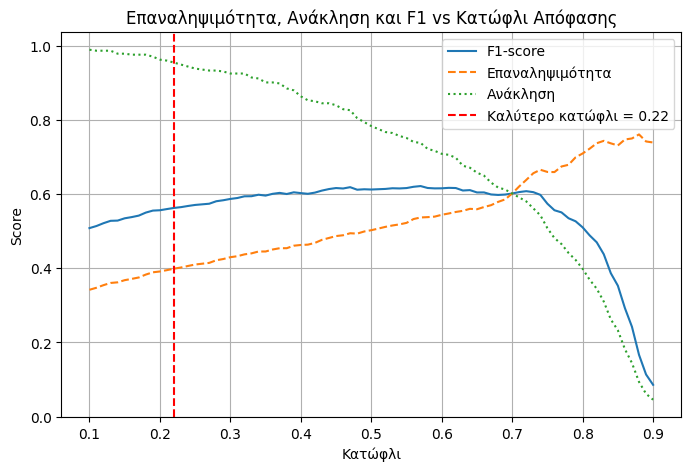

In [19]:
# Βελτιστοποίηση του κατωφλίου απόφασης (decision threshold) για το μοντέλο Νευρωνικού Δικτύου MLP με βέλτιστες υπερπαραμέτρους
f1_scores_nn = []
precisions_nn = []
recalls_nn = []

for th in thresholds:
    y_pred_th = (y_prob_nn_tuned >= th).astype(int)
    precisions_nn.append(precision_score(y_test_NN, y_pred_th))
    recalls_nn.append(recall_score(y_test_NN, y_pred_th))
    f1_scores_nn.append(f1_score(y_test_NN, y_pred_th))

# Επιλογή κατωφλίου που μεγιστοποιεί το F1-score, καθώς θέλουμε ισορροπία μεταξύ precision και recall
best_idx = np.argmax(f1_scores_nn)
best_threshold_nn = thresholds[best_idx]

print(f"Καλύτερο κατώφλι για NN (με βάση το F1): {best_threshold_nn:.2f}")
print(f"Επαναληψιμότητα στο βέλτιστο κατώφλι: {precisions_nn[best_idx]:.3f}")
print(f"Ανάκληση στο βέλτιστο κατώφλι:    {recalls_nn[best_idx]:.3f}")
print(f"F1-score στο βέλτιστο κατώφλι:  {f1_scores_nn[best_idx]:.3f}")
print(50*"-" )

# Δίαγραμμα Επαναληψιμότητα / Ανάκλησης / F1 vs Κατώφλι
plt.figure(figsize=(8,5))
plt.plot(thresholds, f1_scores, label="F1-score")
plt.plot(thresholds, precisions, label="Επαναληψιμότητα", linestyle='--')
plt.plot(thresholds, recalls, label="Ανάκληση", linestyle=':')
plt.axvline(best_threshold_nn, color='red', linestyle='--',
            label=f"Καλύτερο κατώφλι = {best_threshold_nn:.2f}")
plt.xlabel("Κατώφλι")
plt.ylabel("Score")
plt.title("Επαναληψιμότητα, Ανάκληση και F1 vs Κατώφλι Απόφασης")
plt.legend()
plt.grid(True)
plt.show()

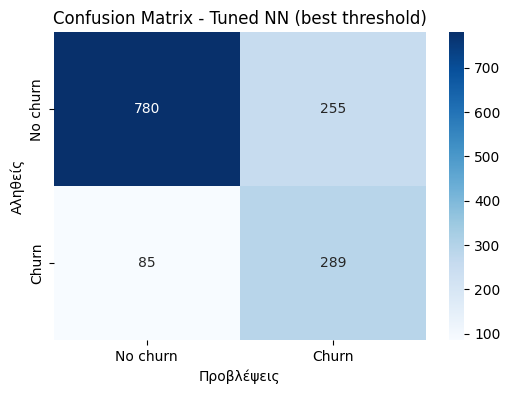

Πίνακας Ταξινόμησης Βέλτιστο Μοντέλο Νευρωνικού Δικτύου (βέλτιστο κατώφλι)::
              precision    recall  f1-score   support

           0       0.90      0.75      0.82      1035
           1       0.53      0.77      0.63       374

    accuracy                           0.76      1409
   macro avg       0.72      0.76      0.73      1409
weighted avg       0.80      0.76      0.77      1409



In [20]:
# Προβλέψεις με χρήση του βέλτιστου κατωφλίου
y_pred_nn_best = (y_prob_nn_tuned >= best_threshold_nn).astype(int)

# # Πίνακας Σύγχυσης (Confusion Matrix) Βέλτιστου Μοντέλου Νευρωνικού Δικτύου
cm_nn_best = confusion_matrix(y_test_NN, y_pred_nn_best)
plt.figure(figsize=(6,4))
sns.heatmap(cm_nn_best, annot=True, fmt='d', cmap='Blues', xticklabels=['No churn', 'Churn'], yticklabels=['No churn', 'Churn'])
plt.title("Confusion Matrix - Tuned NN (best threshold)")
plt.xlabel("Προβλέψεις")
plt.ylabel("Αληθείς")
plt.show()
# Πίνακας Ταξινόμησης Βέλτιστου Μοντέλου Νευρωνικού Δικτύου
print("Πίνακας Ταξινόμησης Βέλτιστο Μοντέλο Νευρωνικού Δικτύου (βέλτιστο κατώφλι)::")
print(classification_report(y_test_NN, y_pred_nn_best))


### Χρησιμοποιήστε μια μέθοδο επεξήγησης (π.χ., SHAP ή LIME) για να ερμηνεύσετε τη σημασία των χαρακτηριστικών

In [21]:
# SHAP για το Νευρωνικό Δίκτυο MLP με βέλτιστες υπερπαραμέτρους

#  Επιλογή μεγέθους background από τα δεδομένα εκπαίδευσης 
background = X_train_NN.sample(300, random_state=42)

# Ορισμός συνάρτησης προβλέψεων
nn_predict_proba = lambda x: best_model.predict(x, verbose=0).ravel()

# Δημιουργία του explainer
explainer_nn = shap.KernelExplainer(nn_predict_proba,background.values)

# Επιλογή σετ δεδομένων για εξήγηση και υπολογισμός SHAP values
X_test_sample = X_test_NN.sample(300, random_state=42)
shap_values_nn = explainer_nn.shap_values(X_test_sample.values, nsamples=100) #array (n_samples, n_features)

Using 300 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/300 [00:00<?, ?it/s]

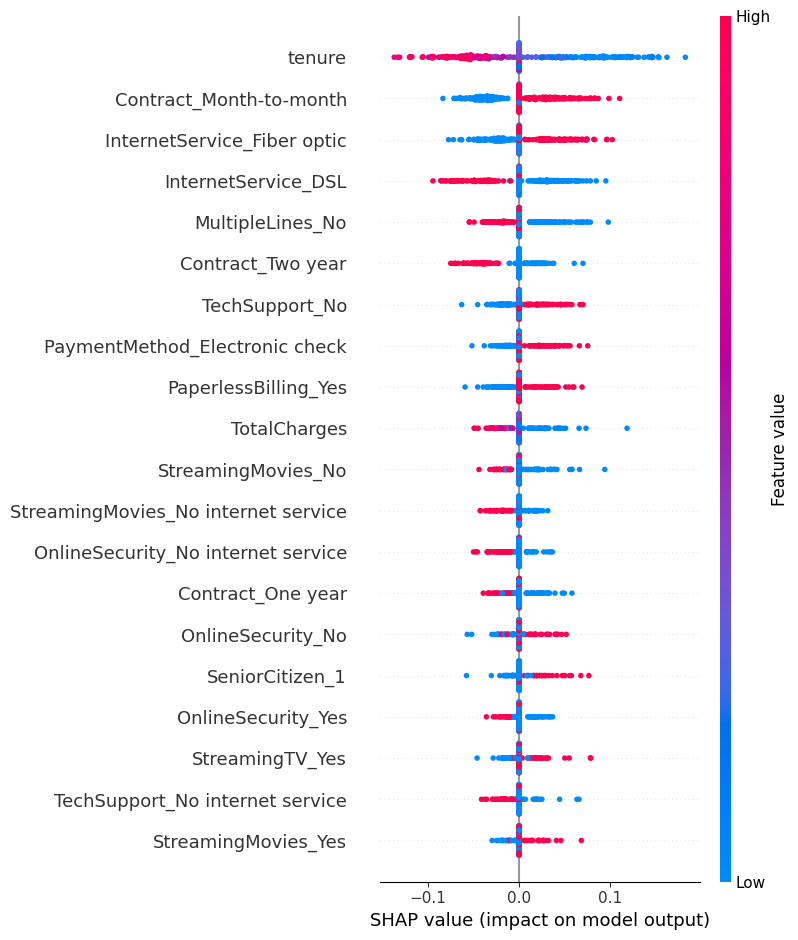

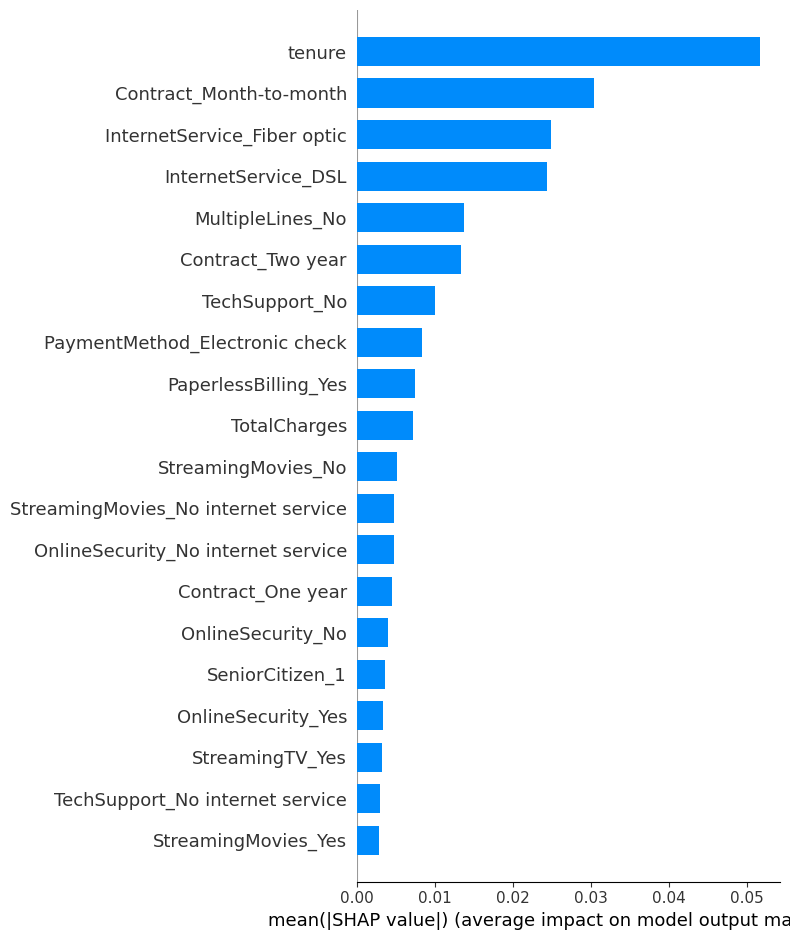

In [22]:
# Global importance + direction of effect
shap.summary_plot(
    shap_values_nn,
    X_test_sample,
    feature_names=X_test_NN.columns
)

# Global importance only
shap.summary_plot(
    shap_values_nn,
    X_test_sample,
    feature_names=X_test_NN.columns,
    plot_type="bar"
)

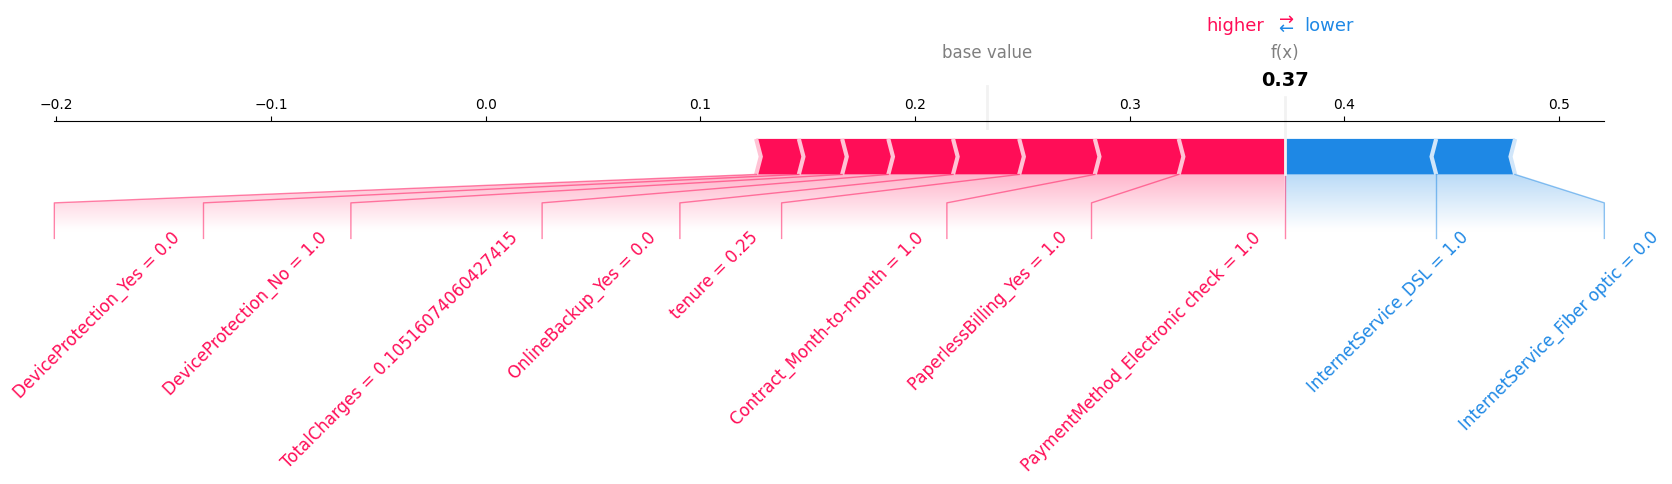

In [23]:
i = np.random.randint(0, len(X_test_sample))
shap.force_plot(
    explainer_nn.expected_value,
    shap_values_nn[1, :],
    X_test_sample.iloc[1, :],
    matplotlib=True,
    text_rotation=45
)

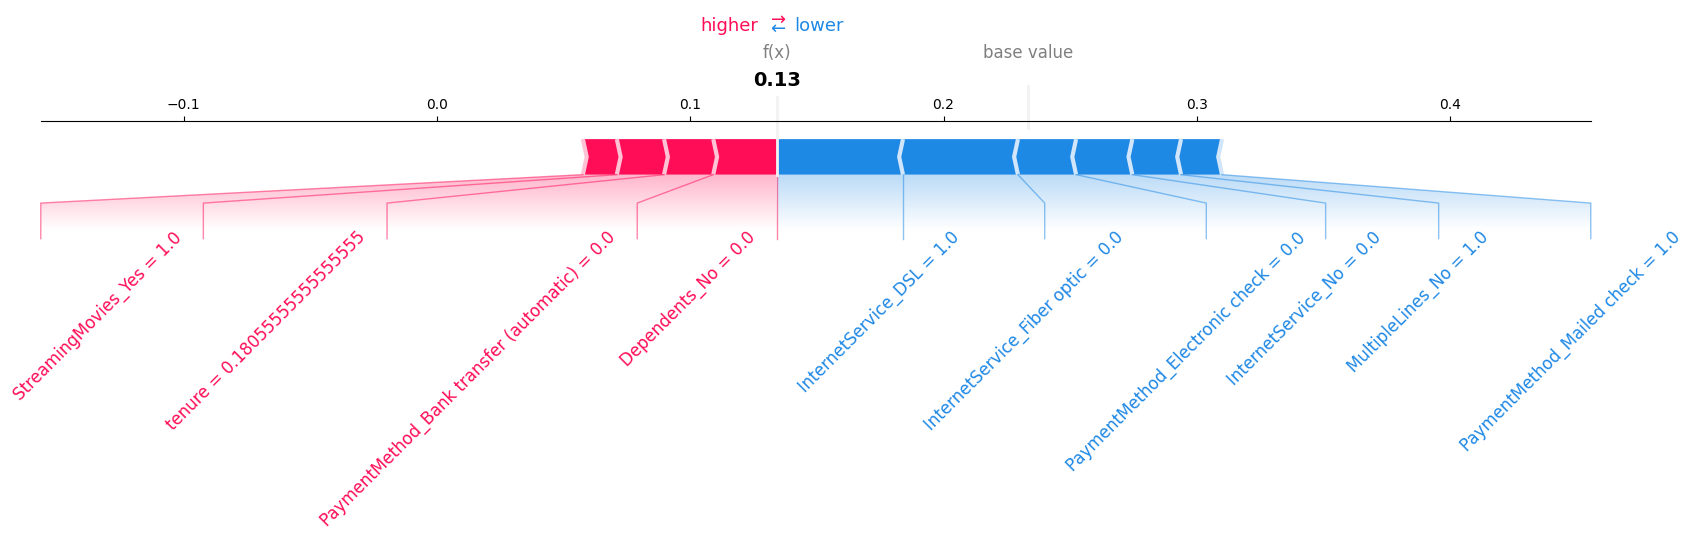

In [24]:
shap.force_plot(
    explainer_nn.expected_value,
    shap_values_nn[100, :],
    X_test_sample.iloc[100, :],
    matplotlib=True,
    text_rotation=45  
)